In [1]:
import os
import glob
from tqdm import tqdm

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import silence_tensorflow.auto
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = 1
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.compat.v1.InteractiveSession(config=config)

# tf.debugging.enable_check_numerics()

import keras
import random
import numpy as np
import matplotlib.pyplot as plt

E0000 00:00:1738524181.884073  557268 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738524181.890263  557268 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1738524185.657441  557268 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3794 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
H = 128
W = 128
C = 3
h = 8

P = 8
assert H == W
assert H % P == 0

D_model = 1024
D_head = 128
D_fcn = 2048
num_layers = 4

N = (H * W) // (P * P)
BATCH_SIZE = 8
FLOAT = tf.float32


In [4]:
DS_SHAPE = (512, 512, 3)


def load_and_validate(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=C, expand_animations=False)
    img = tf.divide(tf.cast(img, dtype=FLOAT), 255.0)
    is_valid = tf.reduce_all(tf.equal(tf.shape(img), tf.constant(DS_SHAPE)))

    return img, is_valid


dataset_path = "/mnt/Data/ML/datasets/portraits"
num_samples = 50


all_files = [
    os.path.join(dataset_path, f)
    for f in os.listdir(dataset_path)
    if f.endswith((".jpg", ".png"))
]
random.shuffle(all_files)
selected_files = all_files[:num_samples]
dataset = tf.data.Dataset.from_tensor_slices(selected_files)
dataset = dataset.map(load_and_validate)
dataset = dataset.filter(lambda img, is_valid: is_valid)  # Keep valid images
dataset = dataset.map(lambda img, is_valid: img)  # remove unused feature
dataset = dataset.map(lambda img: tf.image.resize(img, (H, W)))
print(f"Total files: {len(selected_files)}")

with tf.device("/cpu:0"):
    valid_count = dataset.reduce(
        tf.constant(0, dtype=tf.int32), lambda x, _: x + 1
    ).numpy()

print(f"Valid images count: {valid_count}")
assert valid_count, "Everything's gone"

Total files: 50
Valid images count: 50


In [5]:
def viz_img(img):
    img = tf.cast(img, tf.float32)
    plt.imshow(tf.squeeze(img).numpy(), cmap="gray")
    plt.colorbar()
    plt.show()


def viz_mask(mask):
    plt.imshow(tf.squeeze(mask).numpy(), cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

In [6]:
def prepare_sample(image):
    mask = random_visibility_mask()
    return image, mask


def random_visibility_mask():
    x1 = tf.random.uniform(shape=(), minval=0, maxval=W - 100, dtype=tf.int32)
    y1 = tf.random.uniform(shape=(), minval=0, maxval=H - 100, dtype=tf.int32)
    x2 = tf.random.uniform(shape=(), minval=x1 + 50, maxval=W + 1, dtype=tf.int32)
    y2 = tf.random.uniform(shape=(), minval=y1 + 50, maxval=H + 1, dtype=tf.int32)
    # tf.print(x1,x2,y1,y2)

    mask = tf.ones((H, W), dtype=tf.bool)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.stack(
            [
                tf.repeat(tf.range(y1, y2), x2 - x1),
                tf.tile(tf.range(x1, x2), [y2 - y1]),
            ],
            axis=-1,
        ),
        updates=tf.zeros([(y2 - y1) * (x2 - x1)], dtype=tf.bool),
    )
    return tf.expand_dims(mask, -1)  # expand channel wise


ds_masks = dataset.map(prepare_sample)
train_count = int(valid_count * 0.8)
test_count = int(valid_count * 0.1)
val_count = valid_count - train_count - test_count

train_ds = ds_masks.take(train_count).batch(BATCH_SIZE)
test_ds = ds_masks.skip(train_count).take(test_count).batch(BATCH_SIZE)
val_ds = ds_masks.skip(train_count + test_count).take(val_count).batch(BATCH_SIZE)
print(train_count, test_count, val_count)

train_batches = -(train_count // -BATCH_SIZE)
test_batches =  -(test_count // -BATCH_SIZE)
val_batches =  -(val_count // -BATCH_SIZE)

40 5 5


In [7]:
def extract_patches(image: tf.Tensor) -> tf.Tensor:
    "R^{BS x H x W x C} -> R^{BS x N x P^2 x C}"

    patches: tf.Tensor = tf.image.extract_patches(
        images=image,
        sizes=[1, P, P, 1],  
        strides=[1, P, P, 1], 
        rates=[1, 1, 1, 1], 
        padding="VALID",
    )
    BS, H_prime, W_prime, _ = tf.unstack(tf.shape(patches))

    # Reshape patches to [BS, H' * W', P*P, C]
    patches = tf.reshape(patches, [BS, H_prime * W_prime, P * P, -1])

    return patches


def patches_to_imgs(patches: tf.Tensor) -> tf.Tensor:
    "R^{BS x N x P^2 x C} -> R^{BS x H x W x C}"
    BS = tf.shape(patches)[0]
    grid_size = H // P  # same as W // P
    patches = tf.reshape(patches, [BS, grid_size, grid_size, P, P, C])
    patches = tf.transpose(patches, perm=[0, 1, 3, 2, 4, 5])
    image = tf.reshape(patches, [BS, grid_size * P, grid_size * P, C])

    return image

    
sample = tf.expand_dims(next(iter(dataset.take(1))), 0)
tf.assert_equal(patches_to_imgs(extract_patches(sample)) , sample)

def create_attention_mask(obvmask: tf.Tensor):
    "R^{BS x H x W} -> R^{BS x N x N}"
    BS = tf.shape(obvmask)[0]
    # mask_pooled = tf.nn.avg_pool2d(
    #     tf.cast(obvmask, FLOAT), 
    #     ksize=[P, P],
    #     strides=[P, P],
    #     padding= "VALID"
    #     )
    # mask_pooled = mask_pooled > 0.5  # least 50% observed pixels
    # mask_pooled = tf.reshape(mask_pooled, [BS, N])
    # mask_expanded = tf.expand_dims(mask_pooled, axis=1)
    # mask_expanded = tf.tile(mask_expanded, [1, N, 1]) 
    # A = tf.where(mask_expanded, 0.0, -1e9)

    mask_pooled = tf.nn.max_pool2d(
        tf.cast(
            tf.logical_not(obvmask), dtype=tf.int8
        ),
        ksize=[P, P],
        strides=[P, P],
        padding="VALID",
    )
    mask_pooled = tf.logical_not(tf.cast(mask_pooled, tf.bool))
    # viz_mask(mask_pooled)
    mask_pooled = tf.reshape(mask_pooled, [BS, N])
    mask_expanded = tf.expand_dims(mask_pooled, axis=1)  # (BS, 1, N)
    mask_expanded = tf.tile(mask_expanded, [1, N, 1])  # (BS, N, N)
    A = tf.where(
        mask_expanded,
        tf.constant(0.0, dtype=FLOAT),  # zero penanly
        tf.constant(-float("inf"), dtype=FLOAT),  # inf penalty
    )



    return A

# create_attention_mask(tf.expand_dims(random_visibility_mask(),0))

In [8]:
class PatchEmbedding(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.proj = keras.layers.Dense(D_model, dtype=FLOAT)  # (P² * C) -> D_model

    def build(self, input_shape):
        positions = tf.range(N, dtype=FLOAT)
        positions = tf.expand_dims(positions, 1)  # (N, 1)
        i = tf.range(D_model // 2, dtype=FLOAT)
        div_term = tf.exp((2.0 * i) * (-tf.math.log(10000.0) / D_model))
        angles = positions * div_term  # (N, D_model//2)
        sin_terms = tf.sin(angles)
        cos_terms = tf.cos(angles)

        self.positional_embedding = tf.reshape(
            tf.stack([sin_terms, cos_terms], axis=-1), [N, D_model]
        )
        # tf.print(self.positional_embedding)

    def call(self, patches_flat: tf.Tensor):
        # R^{BS x N x (P^2 . C)} -> R^{BS x N x D_model}
        X = self.proj(patches_flat)
        X += self.positional_embedding
        return X


class MultiHeadAttention(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        # Project to h * D_head dimensions
        self.W_Q = keras.layers.Dense(h * D_head, dtype=FLOAT)
        self.W_K = keras.layers.Dense(h * D_head, dtype=FLOAT)
        self.W_V = keras.layers.Dense(h * D_head, dtype=FLOAT)
        # Project back to D_model
        self.W_O = keras.layers.Dense(D_model, dtype=FLOAT)

    def call(self, X, A):
        # X: R^{BS x N x D_model}
        # A: R^{BS x N x N}
        # returns: R^{BS x N x D_model}

        # In the standard implementation, each head has its own separate projection matrices. However, a common optimization is to project the input into h * D_head dimensions (which is D_model) with a single large projection, then split into h heads. So, if D_model = h * D_head, then using a Dense(D_model) for Q, K, V and then splitting into h heads each of D_head is equivalent to having h separate projections. This is a standard approach because it's more efficient to compute all heads in parallel with a single matrix multiplication rather than h separate ones.
        # So the optimal way is to use combined projections.
        Q = self.W_Q(X)  # (BS, N, h * D_head)
        K = self.W_K(X)  # (BS, N, h * D_head)
        V = self.W_V(X)  # (BS, N, h * D_head)

        Q = tf.reshape(Q, (-1, N, h, D_head))  # (BS, N, h, D_head)
        K = tf.reshape(K, (-1, N, h, D_head))
        V = tf.reshape(V, (-1, N, h, D_head))

        # Transpose for attention computation
        Q = tf.transpose(Q, [0, 2, 1, 3])  # (BS, h, N, D_head)
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.transpose(V, [0, 2, 1, 3])
        # scaled dot-product attention
        attn_scores = tf.matmul(Q, K, transpose_b=True)  # (BS, h, N, N)
        attn_scores /= tf.math.sqrt(
            tf.cast(D_head, attn_scores.dtype)
        )  # scale by sqrt(D_head)

        A = tf.expand_dims(A, 1)  # (BS, 1, N, N)
        attn_scores += A  # Broadcast to all heads

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)  # (BS, h, N, N)

        output = tf.matmul(attn_weights, V)  # (BS, h, N, D_head)
        output = tf.transpose(output, [0, 2, 1, 3])  # (BS, N, h, D_head)
        output = tf.reshape(output, (-1, N, h * D_head))  # (BS, N, h * D_head)
        output = self.W_O(output)  # (BS, N, D_model)
        return output


class TransformerBlock(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.attn = MultiHeadAttention()
        self.norm1 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.norm2 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(D_fcn, activation="gelu", dtype=FLOAT),
                keras.layers.Dense(D_model, dtype=FLOAT),
                # keras.layers.Dropout(0.1, dtype=FLOAT),
            ],
        )

    def call(self, X, A):
        "R^{N x D_model} -> R^{N x D_model}"
        X = self.norm1(X + self.attn(X, A))
        X = self.norm2(X + self.ffn(X))
        return X


class Decoder(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.proj = keras.layers.Dense(P * P * C, dtype=FLOAT)

    def call(self, X):
        "R^{BS x N x D_model} -> R^{BS x N x P x P x C}"
        BS = tf.shape(X)[0]
        X = self.proj(X)
        X = tf.reshape(X, (BS, N, P, P, C))
        return X


class ImageInpaintingTransformer(keras.Model):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.embed = PatchEmbedding()
        self.transformer_blocks = [TransformerBlock() for _ in range(num_layers)]
        self.decoder = Decoder()

    def build(self, input_shape):
        BS = input_shape[0]
        # dummy_images = tf.zeros((BS, H, W, C), dtype=FLOAT)  # THIS WASTED 40 MINUTES
        self.call(*next(iter(val_ds.take(1))))
        self.built = True

    def call(self, image, obvmask):
        image = tf.multiply(image, tf.cast(obvmask, FLOAT))
        # viz_img(image[0])
        patches = extract_patches(image)
        AttnMask = create_attention_mask(obvmask)
        # viz_img(A)

        BS = tf.shape(patches)[0]
        patches_flat = tf.reshape(patches, [BS, N, P**2 * C])
        # tf.print(tf.shape(patches_flat))
        X = self.embed(patches_flat)
        for block in self.transformer_blocks:
            X = block(X, AttnMask)
        reconstructed_patches = self.decoder(X)  # R^{BS x N x P x P x C}
        return patches_to_imgs(reconstructed_patches)


model = ImageInpaintingTransformer()
model.build((BATCH_SIZE, H, W, C))
model.summary()

Model: "image_inpainting_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_embedding                 │ ?                      │       197,632 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ ?                      │     8,399,872 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ ?                      │     8,399,872 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ ?                      │     8,399,872 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ ?                      │     8,399,872 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │       196,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,993,920 (129.68 MB)

 Trainable params: 33,993,920 (129.68 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# model.load_weights("best_run.keras")

In [9]:
session_epochs = 0

In [11]:
@tf.function
def costfunc(y_true: tf.Tensor, y_pred: tf.Tensor, obsvmask: tf.Tensor):
    errors = tf.abs(tf.subtract(y_true, y_pred))
    inpaintmask = tf.cast(tf.logical_not(obsvmask), FLOAT)
    masked_errors = tf.multiply(errors, inpaintmask)
    sum_masked_errors = tf.reduce_sum(masked_errors)
    area = tf.reduce_sum(inpaintmask)
    masked_loss = sum_masked_errors / (area + keras.backend.epsilon())

    global_loss = tf.reduce_mean(errors)

    return masked_loss + global_loss


optimizer = keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)


@tf.function
def train_step(image: tf.Tensor, mask: tf.Tensor):
    with tf.GradientTape() as tape:
        reconstructed_img = model(image, mask)  # N x P x P x C
        loss = costfunc(image, reconstructed_img, mask)
        tf.debugging.check_numerics(loss, "Loss contains NaN or Inf.")
        # if (tf.math.is_nan(loss)):
        # raise Exception("Divergence")
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


@tf.function
def val_step(image: tf.Tensor, mask: tf.Tensor):
    reconstructed_img = model(image, mask, training=False)
    loss = costfunc(image, reconstructed_img, mask)
    return loss


epochs = 50
print("Starting training")

best_val_loss = float("inf")
best_epoch = -1
for _ in range(epochs):
    epoch_loss = 0.0
    steps = 0
    pbar = tqdm(
        train_ds,
        desc=f"Epoch {session_epochs+1}",
        unit="batch",
        total=train_batches,
    )
    for image_batch, mask_batch in pbar:
        loss = train_step(image_batch, mask_batch)
        epoch_loss += loss
        steps += 1
        # Dynamically update the tqdm bar without spamming stdout
        pbar.set_postfix(loss=f"{loss:.4f}")
    train_loss = epoch_loss / steps

    val_loss_total = 0.0
    val_steps = 0
    pbar_val = tqdm(
        val_ds,
        desc=f"Epoch {session_epochs+1} Validation",
        unit="batch",
        total=val_batches,
    )
    for val_image_batch, val_mask_batch in pbar_val:
        loss = val_step(val_image_batch, val_mask_batch)
        val_loss_total += loss
        val_steps += 1
        pbar_val.set_postfix(loss=f"{loss:.4f}")
        
    avg_val_loss = val_loss_total / val_steps
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = session_epochs + 1
        model.save("best_run.keras")
    print(
        f"Epoch {session_epochs+1} Summary: Train Loss = {train_loss:.4f} | Validation Loss = {avg_val_loss:.4f}"
    )
    session_epochs += 1

Starting training


Epoch 1 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.26batch/s, loss=1.5099]


Epoch 1 Summary: Train Loss = 3.0400 | Validation Loss = 1.5099


Epoch 2 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.64batch/s, loss=1.2451]


Epoch 2 Summary: Train Loss = 1.4062 | Validation Loss = 1.2451


Epoch 3 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.37batch/s, loss=1.1823]


Epoch 3 Summary: Train Loss = 1.2057 | Validation Loss = 1.1823


Epoch 4 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.14batch/s, loss=1.0644]


Epoch 4 Summary: Train Loss = 1.1376 | Validation Loss = 1.0644


Epoch 5 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.61batch/s, loss=1.1098]


Epoch 5 Summary: Train Loss = 1.1342 | Validation Loss = 1.1098


Epoch 6 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.58batch/s, loss=1.0305]


Epoch 6 Summary: Train Loss = 1.0904 | Validation Loss = 1.0305


Epoch 7 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.30batch/s, loss=1.0419]


Epoch 7 Summary: Train Loss = 1.0720 | Validation Loss = 1.0419


Epoch 8 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.00batch/s, loss=1.0857]


Epoch 8 Summary: Train Loss = 1.0499 | Validation Loss = 1.0857


Epoch 9 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.89batch/s, loss=1.0403]


Epoch 9 Summary: Train Loss = 1.0654 | Validation Loss = 1.0403


Epoch 10 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.55batch/s, loss=1.0501]


Epoch 10 Summary: Train Loss = 1.0574 | Validation Loss = 1.0501


Epoch 11 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.61batch/s, loss=1.1190]


Epoch 11 Summary: Train Loss = 1.0666 | Validation Loss = 1.1190


Epoch 12 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.89batch/s, loss=1.1332]


Epoch 12 Summary: Train Loss = 0.9950 | Validation Loss = 1.1332


Epoch 13 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.86batch/s, loss=1.0440]


Epoch 13 Summary: Train Loss = 1.0558 | Validation Loss = 1.0440


Epoch 14 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.86batch/s, loss=1.0472]


Epoch 14 Summary: Train Loss = 1.0066 | Validation Loss = 1.0472


Epoch 15 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.84batch/s, loss=1.0826]


Epoch 15 Summary: Train Loss = 1.0180 | Validation Loss = 1.0826


Epoch 16 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.99batch/s, loss=1.0599]


Epoch 16 Summary: Train Loss = 0.9658 | Validation Loss = 1.0599


Epoch 17 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.67batch/s, loss=1.0633]


Epoch 17 Summary: Train Loss = 0.9641 | Validation Loss = 1.0633


Epoch 18 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.76batch/s, loss=1.0139]


Epoch 18 Summary: Train Loss = 0.9673 | Validation Loss = 1.0139


Epoch 19 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.92batch/s, loss=1.1152]


Epoch 19 Summary: Train Loss = 0.9533 | Validation Loss = 1.1152


Epoch 20 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.90batch/s, loss=1.0713]


Epoch 20 Summary: Train Loss = 0.9692 | Validation Loss = 1.0713


Epoch 21 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.00batch/s, loss=1.0283]


Epoch 21 Summary: Train Loss = 0.9366 | Validation Loss = 1.0283


Epoch 22 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.60batch/s, loss=1.0600]


Epoch 22 Summary: Train Loss = 0.9706 | Validation Loss = 1.0600


Epoch 23 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.51batch/s, loss=1.1723]


Epoch 23 Summary: Train Loss = 1.0199 | Validation Loss = 1.1723


Epoch 24 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.71batch/s, loss=1.1269]


Epoch 24 Summary: Train Loss = 0.9796 | Validation Loss = 1.1269


Epoch 25 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.71batch/s, loss=1.0504]


Epoch 25 Summary: Train Loss = 0.9907 | Validation Loss = 1.0504


Epoch 26 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.48batch/s, loss=1.0052]


Epoch 26 Summary: Train Loss = 0.9941 | Validation Loss = 1.0052


Epoch 27 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.54batch/s, loss=1.0610]


Epoch 27 Summary: Train Loss = 0.9541 | Validation Loss = 1.0610


Epoch 28 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.72batch/s, loss=1.0720]


Epoch 28 Summary: Train Loss = 0.9742 | Validation Loss = 1.0720


Epoch 29 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.17batch/s, loss=1.2060]


Epoch 29 Summary: Train Loss = 1.0066 | Validation Loss = 1.2060


Epoch 30 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.39batch/s, loss=1.0557]


Epoch 30 Summary: Train Loss = 0.9554 | Validation Loss = 1.0557


Epoch 31 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.00batch/s, loss=1.1314]


Epoch 31 Summary: Train Loss = 0.9551 | Validation Loss = 1.1314


Epoch 32 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.79batch/s, loss=1.0982]


Epoch 32 Summary: Train Loss = 0.9350 | Validation Loss = 1.0982


Epoch 33 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.64batch/s, loss=1.0345]


Epoch 33 Summary: Train Loss = 0.9320 | Validation Loss = 1.0345


Epoch 34 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.78batch/s, loss=1.1328]


Epoch 34 Summary: Train Loss = 0.9904 | Validation Loss = 1.1328


Epoch 35 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.66batch/s, loss=1.0157]


Epoch 35 Summary: Train Loss = 0.9048 | Validation Loss = 1.0157


Epoch 36 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.01batch/s, loss=1.1535]


Epoch 36 Summary: Train Loss = 0.9392 | Validation Loss = 1.1535


Epoch 37 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.44batch/s, loss=1.0657]


Epoch 37 Summary: Train Loss = 0.9296 | Validation Loss = 1.0657


Epoch 38 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.69batch/s, loss=1.1114]


Epoch 38 Summary: Train Loss = 0.8975 | Validation Loss = 1.1114


Epoch 39 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.57batch/s, loss=1.0316]


Epoch 39 Summary: Train Loss = 0.9295 | Validation Loss = 1.0316


Epoch 40 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.53batch/s, loss=1.0814]


Epoch 40 Summary: Train Loss = 0.9093 | Validation Loss = 1.0814


Epoch 41 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.27batch/s, loss=1.0240]


Epoch 41 Summary: Train Loss = 0.9237 | Validation Loss = 1.0240


Epoch 42 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.62batch/s, loss=1.1320]


Epoch 42 Summary: Train Loss = 0.9672 | Validation Loss = 1.1320


Epoch 43 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.39batch/s, loss=1.1872]


Epoch 43 Summary: Train Loss = 0.9725 | Validation Loss = 1.1872


Epoch 44 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.64batch/s, loss=1.0883]


Epoch 44 Summary: Train Loss = 0.9836 | Validation Loss = 1.0883


Epoch 45 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.86batch/s, loss=1.1370]


Epoch 45 Summary: Train Loss = 0.9851 | Validation Loss = 1.1370


Epoch 46 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.94batch/s, loss=1.0204]


Epoch 46 Summary: Train Loss = 0.9414 | Validation Loss = 1.0204


Epoch 47 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.70batch/s, loss=1.1174]


Epoch 47 Summary: Train Loss = 0.9421 | Validation Loss = 1.1174


Epoch 48 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.97batch/s, loss=1.2219]


Epoch 48 Summary: Train Loss = 0.9102 | Validation Loss = 1.2219


Epoch 49 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.57batch/s, loss=1.1414]


Epoch 49 Summary: Train Loss = 0.9121 | Validation Loss = 1.1414


Epoch 50 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.91batch/s, loss=1.0618]

Epoch 50 Summary: Train Loss = 0.9502 | Validation Loss = 1.0618


In [21]:
# model.save("br3.keras")
# model.load_weights("best_run.keras")

In [10]:
def apply_obsv_mask(image: tf.Tensor, obvmask: tf.Tensor) -> tf.Tensor:
    return tf.multiply(image, tf.cast(obvmask, FLOAT))


def viz_grid(batch: tf.Tensor):
    batch_size: int = batch.shape[0]  # type: ignore
    fig, axes = plt.subplots(nrows=1, ncols=batch_size, figsize=(15, 15), dpi=300)
    if batch_size == 1:
        axes = [axes]
    for i in range(batch_size):
        # Original image
        axes[i].imshow(
            tf.clip_by_value(
                tf.cast(batch[i], dtype=tf.float32), 0, 1  # type: ignore
            ).numpy() # type: ignore
        )
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


def reconstruct(original: tf.Tensor, reconstruct: tf.Tensor, obvmask: tf.Tensor):
    return tf.add(
        tf.multiply(tf.cast(obvmask, FLOAT), original),
        tf.multiply(tf.cast(tf.logical_not(obvmask), FLOAT), reconstruct),
    )

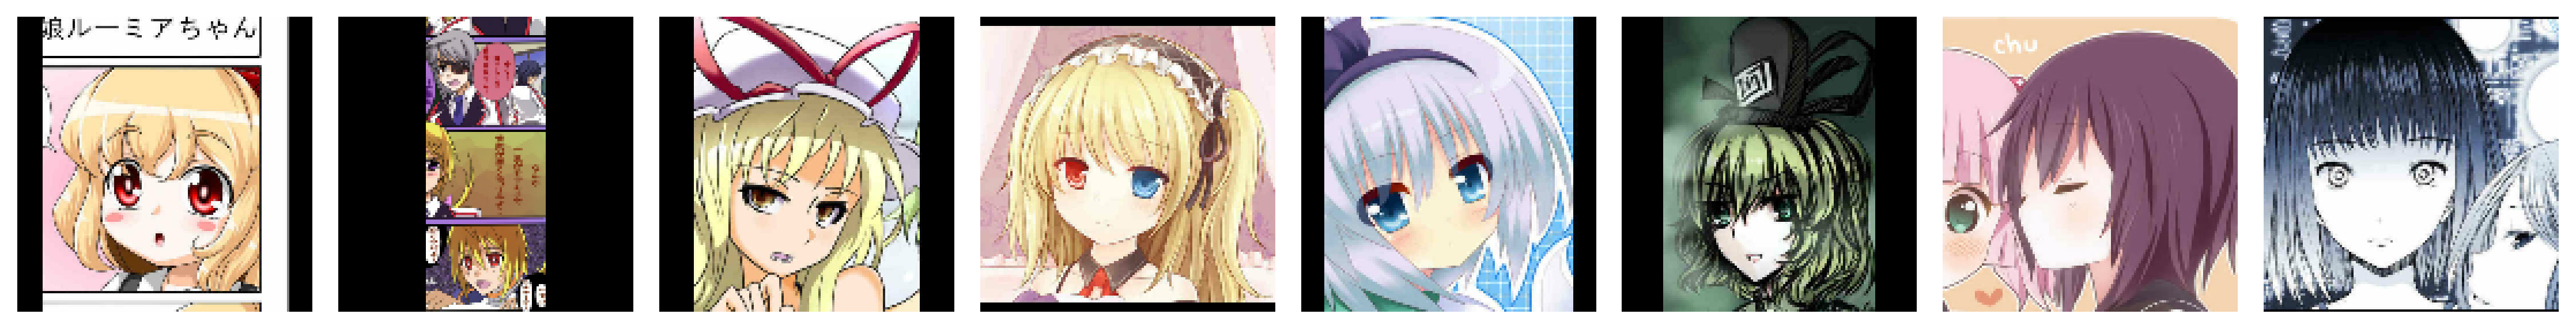

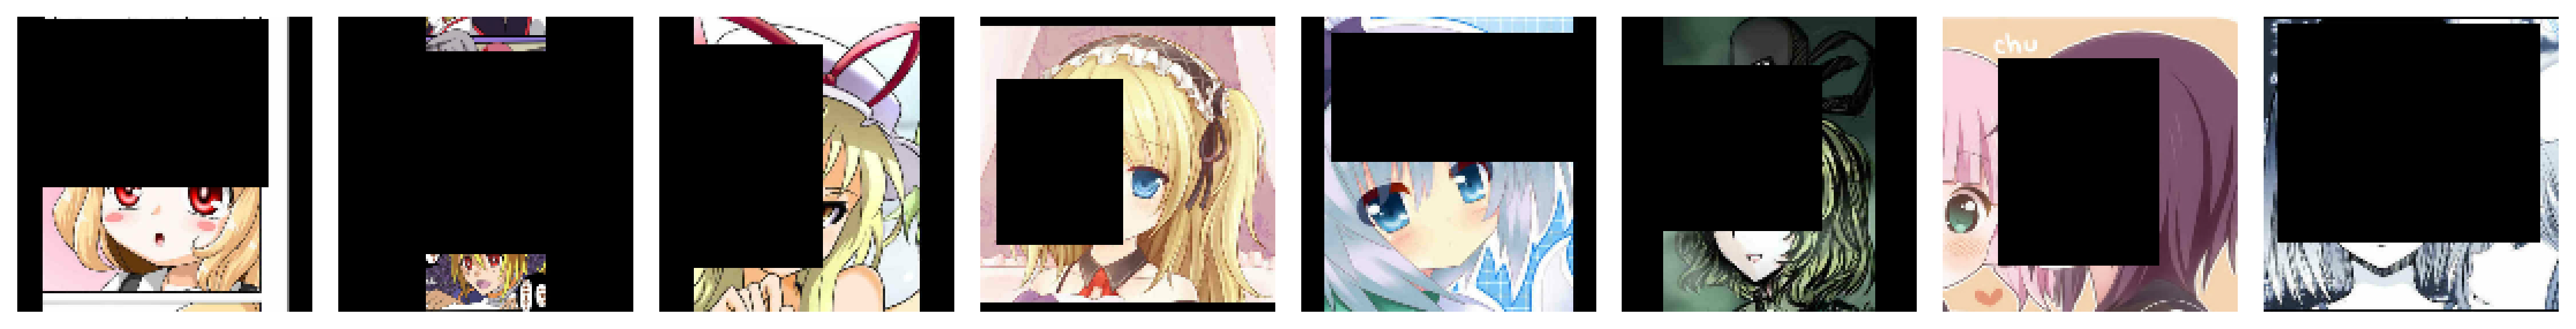

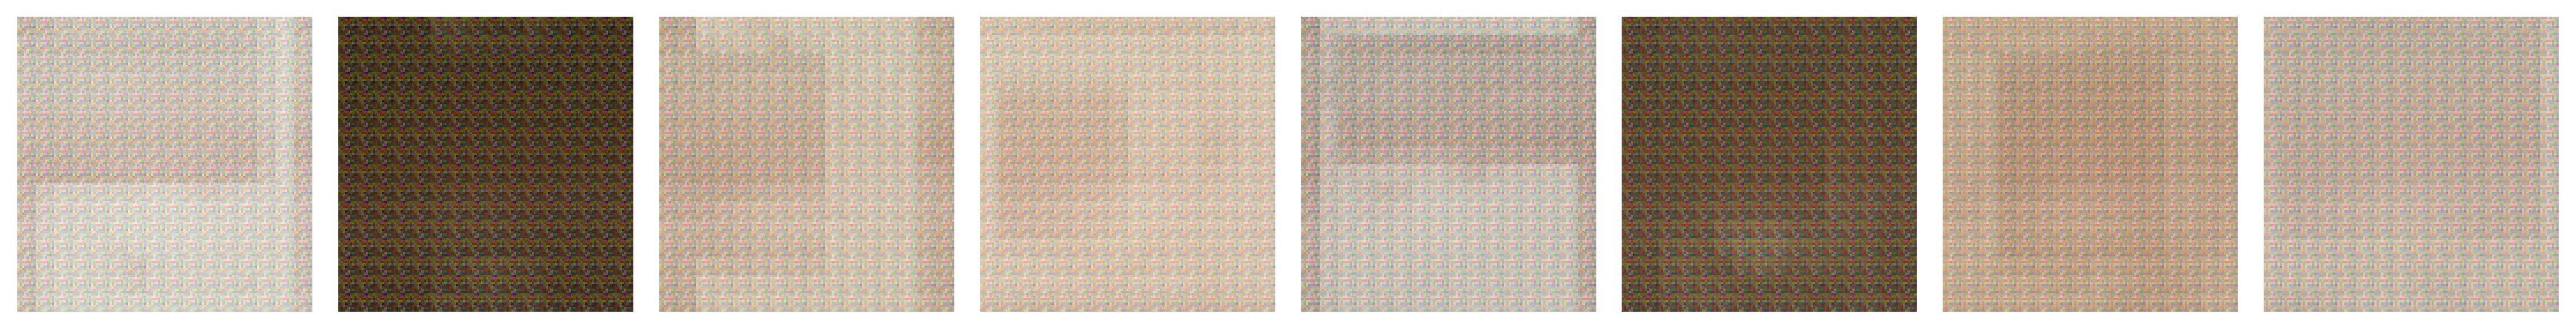

In [12]:
# Qualitative Eval
# visualize_unbatched_dataset(test_ds, 5)


# img = tf.image.decode_image(
#     tf.io.read_file("/home/navid/Dev/PaperTex/impl/naruto")
#     , dtype=tf.float32)
# img = tf.image.resize_with_crop_or_pad(img, H, W)
# img = tf.expand_dims(img, 0)
# tf.print(tf.shape(img))
# obvmask = tf.expand_dims(random_visibility_mask(),0)
# tf.print(tf.shape(obvmask))


img, obvmask = next(iter(train_ds.take(1)))
viz_grid(img)
viz_grid(apply_obsv_mask(img, obvmask))
model_out = model(img, obvmask)
# reconstructed = reconstruct(img, model(img, obvmask), obvmask)
viz_grid(model_out)

# viz_img(model_out[0])
# viz_img(img[0])